In [78]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import sys
sys.path.append('.')

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import FunctionTransformer as FT
from sklearn.impute import SimpleImputer

from lib.Datasets import TabularDataset
from lib.Transformers import NumericalTransformer, CategoricalTransformer, CategoricalTargetTransformer, DatasetTransformer
from lib.Runner import Runner

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor, Tensor
from torch.optim import Optimizer
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR
from torch.utils.data import DataLoader

##### Reproducibility

In [80]:
torch.manual_seed(0)
np.random.seed(0)

### Dataset's

In [81]:
X_train_df = pd.read_csv('inputs/train.csv', low_memory=False).sort_values('SKU', ascending=True)

X_train = X_train_df.to_dict('records')
Y_train = X_train_df['VENTA_ALTA'].values
print('{0:,} registros a las {1}'.format(len(X_train), datetime.now()))
X_train[0], Y_train[0]

48,610 registros a las 2020-11-27 00:24:04.301735


({'ORDEN': 63770,
  'SKU': 50001,
  'MARKETING': 'S',
  'ACTUALIZACIONES': 8,
  'ACTUALIZADO': 1,
  'VENTAS_ACUMULADAS': 2167227,
  'PRICE': 149.35,
  'LANZAMIENTO': 2003,
  'CANTIDAD': 32,
  'PRECIO_MIN': 176.23,
  'SD_PRECIO': 65.27,
  'VENTA_ALTA': 0},
 0)

In [82]:
X_validation_df = pd.read_csv('inputs/validation.csv', low_memory=False).sort_values('SKU', ascending=True)

X_validation = X_validation_df.to_dict('records')
Y_validation = X_validation_df['VENTA_ALTA'].values
print('{0:,} registros a las {1}'.format(len(X_validation), datetime.now()))
X_validation[0], Y_validation[0]

12,156 registros a las 2020-11-27 00:24:04.649805


({'ORDEN': 5550,
  'SKU': 50005,
  'MARKETING': 'D',
  'ACTUALIZACIONES': 7,
  'ACTUALIZADO': 1,
  'VENTAS_ACUMULADAS': 247778,
  'PRICE': 128.95,
  'LANZAMIENTO': 2008,
  'CANTIDAD': 81,
  'PRECIO_MIN': 72.93,
  'SD_PRECIO': 21.74,
  'VENTA_ALTA': 0},
 0)

### Transformations & Feature enginnering

In [83]:
def get_price(X):
    prices = np.array(X['PRICE'], dtype=np.float64)
    min_prices = np.array(X['PRECIO_MIN'], dtype=np.float64)
    sd_prices = np.array(X['SD_PRECIO'], dtype=np.float64)
    
    return [price if price > 0 else min_price+sd_price for price, min_price, sd_price in zip(prices, min_prices, sd_prices)]

def get_discount(X):
    prices = np.array(X['PRICE'], dtype=np.float64)
    min_prices = np.array(X['PRECIO_MIN'], dtype=np.float64)
    sd_prices = np.array(X['SD_PRECIO'], dtype=np.float64)
    
    new_prices = [price if price > 0 else min_price+sd_price for price, min_price, sd_price in zip(prices, min_prices, sd_prices)]
    return 1 - np.array(new_prices, dtype=np.int32)/np.array(X['PRECIO_MIN'], dtype=np.float64)

In [84]:
dataset_transformer = DatasetTransformer([
    # Categorical features
    #('orden', CategoricalTransformer('ORDEN', handle_unknown=True)),
    #('sku', CategoricalTransformer('SKU', handle_unknown=True)),
    ('marketing', CategoricalTransformer('MARKETING', handle_unknown=True)),
    ('has_updated', CategoricalTransformer('ACTUALIZADO', handle_unknown=True)),
    ('launch', CategoricalTransformer('LANZAMIENTO', handle_unknown=True)),
    
    # Numerical features
    ('updates', NumericalTransformer('ACTUALIZACIONES')),
    ('quantity', NumericalTransformer('CANTIDAD')),
    #('price', NumericalTransformer(log=True, scaler=False, pre_tfms=[FT(get_price)], dtype=np.float64)),
    ('price', NumericalTransformer(pre_tfms=[FT(get_price)])),
    ('accumulated_sales', NumericalTransformer('VENTAS_ACUMULADAS')),
    ('percentage_discount', NumericalTransformer(pre_tfms=[FT(get_discount)]))
])

target_transformer = CategoricalTargetTransformer('high_sales')

In [85]:
%%time
X_train_numerical, X_train_categorical = dataset_transformer.fit_transform(X_train)
target_train = target_transformer.fit_transform(Y_train)

KeyError: 'original_price'

In [86]:
%%time
X_validation_numerical, X_validation_categorical = dataset_transformer.transform(X_validation)
target_validation = target_transformer.transform(Y_validation)

KeyError: 'original_price'

### Datasets and Dataloaders

In [87]:
train_ds = TabularDataset(X_train_numerical, X_train_categorical, target_train, torch.float)
validation_ds = TabularDataset(X_validation_numerical, X_validation_categorical, target_validation, torch.float)
#test_ds = TabularDataset(X_test_numerical, X_test_categorical)

In [88]:
train_dl = DataLoader(train_ds, batch_size=1024, shuffle=True)
validation_dl = DataLoader(validation_ds, batch_size=1024, shuffle=False)
#test_dl = DataLoader(test_ds, batch_size=1024, shuffle=False)

### Model

In [89]:
class Model(nn.Module):
    def __init__(self, q_numerical_features, q_categorical_features, hidden_layers_size, embedding_dims=None):
        super(Model, self).__init__()
        
        self.hidden_layers_size = hidden_layers_size
        
        if embedding_dims is not None:
            embedding_sizes = sum([embedding_size for _, embedding_size in embedding_dims])
            self.embeddings_layer=nn.ModuleList(
                [nn.Embedding(vocabulary_size, embedding_size) for vocabulary_size, embedding_size in embedding_dims]
            )
            self.embedding_dropout = nn.Dropout(0.1)
        else:
            embedding_sizes = 0
            self.embeddings_layer = None
        
        self.layer_0 = nn.Sequential(
            nn.Linear(embedding_sizes + q_numerical_features, hidden_layers_size[0], bias=True),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(hidden_layers_size[0]),            
        ) 
        
        for i, hidden_size in enumerate(hidden_layers_size[1:]):
            layer = nn.Sequential(
                nn.Linear(hidden_layers_size[i], hidden_layers_size[i+1], bias=True),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.BatchNorm1d(hidden_layers_size[i+1]),            
            )
            setattr(self, f'layer_{i+1}', layer)
        
        self.output = nn.Sequential(
            nn.Linear(hidden_layers_size[-1], 1, bias=True),
            nn.Sigmoid()
        )
        
    def forward(self, numerical_features:Tensor, categorical_features:Tensor) -> Tensor:
        if self.embeddings_layer is not None:
            embeds = [emb_layer(categorical_features[:, i]) for i, emb_layer in enumerate(self.embeddings_layer)] 
            embeds = torch.cat(embeds, 1)
            x = self.embedding_dropout(embeds)
        else:
            embeds = tensor([])
        
        x = self.layer_0(torch.cat([embeds, numerical_features], 1))
        for i in range(1, len(self.hidden_layers_size)):
            x = getattr(self, f'layer_{i}')(x)
        
        return self.output(x)

### Training the network

In [95]:
embedding_dims = dataset_transformer.get_embeddings_size()
numerical_features_quantity, categorical_features_quantity = dataset_transformer.get_features_quantity()
numerical_features_quantity, categorical_features_quantity

(5, 3)

In [94]:
model = Model(
    q_numerical_features = numerical_features_quantity, 
    q_categorical_features = categorical_features_quantity,
    hidden_layers_size=[64,32],
    embedding_dims=embedding_dims
)
optimizer = Adam(model.parameters(), lr=.1)#, weight_decay=0.01)
scheduler = ExponentialLR(optimizer=optimizer, gamma=0.95)
loss_fn = nn.BCELoss(reduction='mean')

runner = Runner(model=model, optimizer=optimizer, loss_fn=loss_fn, batch_scheduler=scheduler)
model

Model(
  (embeddings_layer): ModuleList(
    (0): Embedding(3, 1)
    (1): Embedding(3, 1)
    (2): Embedding(66, 33)
  )
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (layer_0): Sequential(
    (0): Linear(in_features=40, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_1): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [92]:
%%time
losses = runner.fit(train_dl, validation_dl, epochs=5)

RuntimeError: size mismatch, m1: [1024 x 39], m2: [40 x 64] at ..\aten\src\TH/generic/THTensorMath.cpp:41

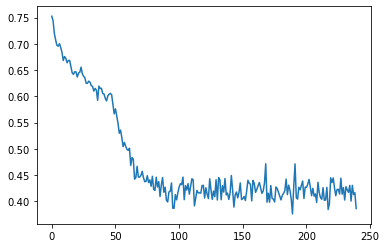

In [16]:
plt.plot(range(len(losses)), losses)

### Validating the net

In [43]:
y_train_pred = runner.predict(DataLoader(train_dl.dataset, train_dl.batch_size))

In [44]:
y_val_pred = runner.predict(validation_dl)

In [19]:
#y_test_pred = runner.predict(test_dl)

#### Training

In [45]:
aucroc_train = roc_auc_score(target_train, y_train_pred)
print(f'Auc Roc in training: {aucroc_train}')

Auc Roc in training: 0.744496502427967


#### Validation

In [46]:
aucroc_val = roc_auc_score(target_validation, y_val_pred)
print(f'Auc Roc in test: {aucroc_val}')

Auc Roc in test: 0.742981918781307


#### Testing submission

In [22]:
submission = pd.DataFrame({
    'conversion': y_test_pred.squeeze()
}).reset_index().rename({'index':'ROW_ID'}, axis=1)
submission['conversion'] = np.round(submission['conversion'], 4)
submission.tail()

NameError: name 'y_test_pred' is not defined

In [ ]:
submission.to_csv('submission_2020_09_22_002.csv.gz', compression='gzip', index=False)